# Optimail Trading in Mean-Rerverting Market With Reinforcement Learning

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Price Process

In [2]:
# Ornstein Uhlenbeck
class OU:
    
    def __init__(self, s0, mean, volatility, mean_reversion_rate):
        
        # Model parameters
        self.s0 = s0
        self.mean = mean
        self.vol = volatility
        self.mrr = mean_reversion_rate
        
        # state variables
        self.t = 0.0
        self.s = s0
        
    def state(self):
        return self.t, self.s
    
    def reset(self):
        self.s = self.s0
        self.t = 0.0
        return self.state()
        
    def step(self, dt=1.0/252):
        etr = np.exp(-dt * self.mrr)
        mu = self.s * etr + self.mean*(1.0 - etr)
        var = self.vol**2 * (1.0 - np.exp(-2*dt*self.mrr)) / (2.0 * self.mrr)
        
        self.s = np.random.normal(mu, var**0.5)
        self.t += dt
        return self.state()
        

## Create a Price Process instance

In [3]:
ou = OU(
    s0=0.2, 
    mean=0.0,
    volatility=2.0,
    mean_reversion_rate=20.0
)

## Plot 10  price scenarios

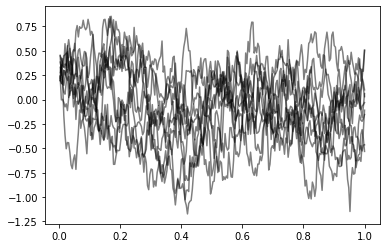

In [4]:
for _ in range(10):
    
    # reset the price process to an initial state
    ou.reset()
    
    # create a path of 252 steps
    price_path = [ou.step() for _ in range(252)]
    
    # unpack list of tuples [(t,St), ..] into a separate t and St list
    price_path = list(zip(*price_path))

    # plot this path
    plt.plot(*price_path, 'k-',alpha=.5)
    
plt.show()

# Trading Environment

```
class MyEnv(gym.Env):


    def __init__(self, ...)
    
        self.action_space = ...
        self.observation_space = ...


    def reset(self):
        # start a new trading session
        ...
        return state


    def step(self, action):
        # Do an action and move forward in time:
        # - see how the world changes
        # - compute the rewards 
        # return the new state, the rewardm, and an indicator that shows if we are done
        ...
        return state, reward, done, {}
        

    def render(self):
        # Visualize the current enviroment or the episode so far.
        ...
```

In [5]:
import gym
from gym import spaces

# Custom Environment that follows gym interface
class TradeEnv(gym.Env):

    def __init__(self, price_process, transaction_cost=0.05):
        super(TradeEnv, self).__init__()

        # Define the action space. 
        # This env has 3 actions:
        #   0 go short, pos == -1. Sell (if needed) so that we end up with -1 stock
        #   1 go neutral, pos == 0. Buy / sell the current stock and end up with 0 stock
        #   2 go long, pos == 1. Buy stock (if needed) so that we end up with -1 stock
        self.action_space = spaces.Discrete(3)

        
        # Define observation (state) space.
        # This environment has a state space of 3 floats
        #   0 time [0, 1]
        #   1 current stock price
        #   2 current position {-1,0,1}
        low = np.array([np.single(0),  np.finfo(np.float32).min, np.single(-1)])
        high = np.array([np.single(1), np.finfo(np.float32).max, np.single(1)])
    
        self.observation_space = spaces.Box(low, high, dtype=np.float32)

        # Constants
        self.dt = 1.0 / 252 # timestep
        self.price_process = price_process
        self.transaction_cost = transaction_cost
        
        # Position variables that change during simulation
        self.pos = 0.0
        
        # we keep a log of the action, state, reward so that we can render it
        self.log = []
    
    
    # return the state of the environment
    def state(self):
        return np.array([*self.price_process.state(), self.pos])
    
    
    # Reset the environemnt
    def reset(self):
        self.pos = 0.0
        self.price_process.reset()
        self.log = []
        return self.state()
    
    # Decode the action number into a target postion (-1,0,1)
    def action_to_target_pos(self, action):
        return action - 1.0
    
    
    # Execute one time-step within the environment
    #   first we buy or sell stocks based on the action
    #   then we move the stock forward in time
    #   finally we return the state
    def step(self, action):
        
        # decode the action
        target_pos = self.action_to_target_pos(action)
        
        # compute transaction fees
        fees = np.abs(target_pos - self.pos) * self.transaction_cost
        
        # set the position to the target position
        self.pos = target_pos
        
        # save the current stock price, before we move foward in time
        # we need this to compute position profits due to the stock movement
        t_, s_ = self.price_process.state()
        
        # move forward in time
        t, s = self.price_process.step(self.dt)
        
        # Compute the position profits
        pos_profit = (s - s_) * self.pos
        
        # reward
        reward = pos_profit - fees
        
        # stop condition
        done = (t >= 1.0)
        
        # log
        self.log.append((action, *self.state(), reward))
        
        return self.state(), reward, done, {}
    
    
    def render(self):
        action, t, stock, pos, reward = zip(*env.log)
        
        fig, axs = plt.subplots(3, 1, figsize=(8, 8), sharex=True)
        axs[0].plot(t, stock, 'k')
        axs[1].plot(t, pos, 'k')
        axs[2].plot(t, np.cumsum(reward), 'k')
        
        for ax,title in zip(axs, ('Stock', 'Pos', 'Cummulative reward')):
            ax.set_title(title)
        
        plt.tight_layout()
        plt.show()

## Create an environment instance

In [6]:
env = TradeEnv(price_process=ou)

## Developer step:  Check if the enviroment correctly implements the gym interface

In [7]:
from stable_baselines3.common.env_checker import check_env
check_env(env)

# Example trading session

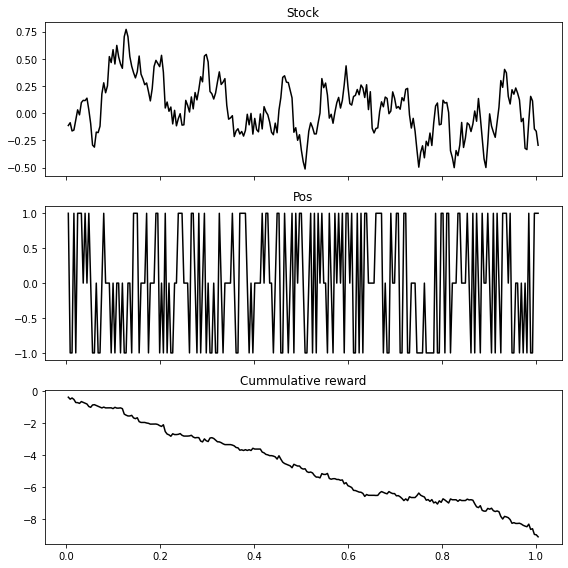

In [8]:
state = env.reset()
done = False
total_reward = 0.0


while not done:
    
    # random action
    action = np.random.randint(3)
    
    # evaluate the action
    state, reward, done, _ = env.step(action)
    
env.render()

# Reinforcement learning

In [9]:
import torch.nn as nn
from stable_baselines3 import PPO
from stable_baselines3.ppo import MlpPolicy
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy

## Create a policy network

In [10]:
model = PPO(MlpPolicy, env)

## Train the policy

In [11]:
train_rewards = []

for i in range(100):
    
    # Train
    model.learn(total_timesteps=100)
    
    # evaluate  performance
    mean_reward, std_reward = evaluate_policy(model, model.get_env(), n_eval_episodes=10)
    
    # print and log stats
    if i%10 == 0:
        print(f'{i:4d}  {mean_reward:5.3f}')
    train_rewards.append(mean_reward)

   0  0.000
  10  2.678
  20  3.766
  30  3.123
  40  3.338
  50  3.303
  60  3.886
  70  3.842
  80  3.302
  90  3.011


## Plot training results

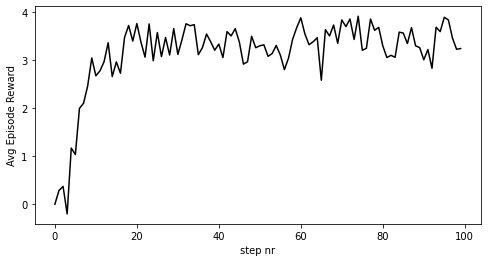

In [12]:
fig, ax = plt.subplots(1,1,figsize=(8,4))
ax.plot(train_rewards, 'k-')
ax.set_ylabel('Avg Episode Reward')
ax.set_xlabel('step nr')
plt.show()

## Show the policy in action

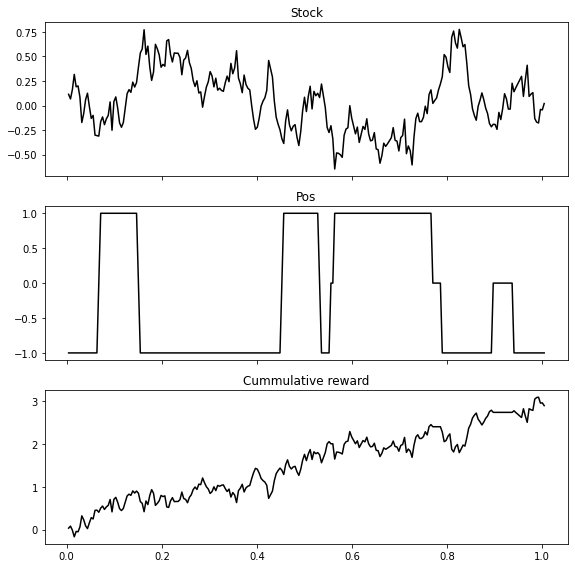

In [13]:
state = env.reset()
done = False

while not done:
    
    # policy action
    action, _ = model.predict(state)
    
    # evaluate the action
    state, reward, done, _ = env.step(action)
    
env.render()